## Install & Import Library

In [ ]:
!pip install tensorflow_addons 
!pip install face_recognition

In [ ]:
import tensorflow as tf
import inspect
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model


import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import face_recognition
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import random as python_random
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
np.random.seed(1234)
python_random.seed(1234)
tf.random.set_seed(1234)

## Load Data

In [ ]:
from google.colab import drive
import pandas as pd


drive.mount('/content/drive/')

In [ ]:
data_path = "/content/drive/MyDrive/DataBDC/data fix/Crop + rotation 20%"
training_path0 = '/content/drive/MyDrive/DataBDC/Training/'
testing_path = '/content/drive/MyDrive/DataBDC/Testing'
data = pd.read_csv('/content/drive/MyDrive/DataBDC/train_data_fix.csv')
data['Gender label'] = data['jenis kelamin'].map({0: 'Perempuan', 1: 'Laki-laki'})

train_label = pd.read_csv('/content/drive/MyDrive/DataBDC/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/DataBDC/submission.csv')


## Exploratory Data Analysis

In [ ]:
train_label.head()

nomor  jenis kelamin  usia
0      1              0    27
1      2              1    24
2      3              0    29
3      4              1    23
4      5              0    20

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310 entries, 0 to 2309
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image path       2310 non-null   object
 1   jenis kelamin    2310 non-null   int64 
 2   usia             2310 non-null   int64 
 3   image path baru  2310 non-null   object
dtypes: int64(2), object(2)
memory usage: 72.3+ KB


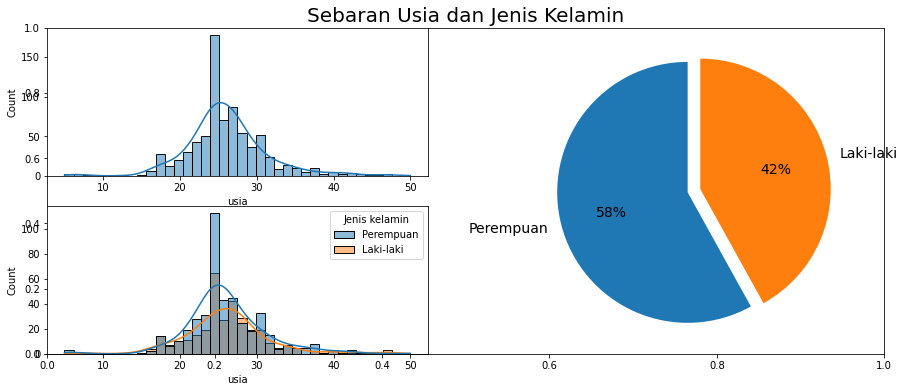

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(15, 6))
gs = GridSpec(nrows=2, ncols=2)
plt.title('Sebaran Usia dan Jenis Kelamin',fontsize=20)

ax0 = fig.add_subplot(gs[0, 0])
sns.histplot(data=train_label, x="usia",kde=True,bins=38)

ax1 = fig.add_subplot(gs[:, 1])
colors = ['tab:blue', 'tab:orange', 't']
plt.pie(data['Gender label'].value_counts(), labels=data['Gender label'].value_counts().index, autopct="%1.0f%%", textprops=dict(size=14), startangle=90, explode=tuple([0.05] * 2), colors=colors)
plt.axis("off")

d = train_label.rename(columns={'jenis kelamin': 'Jenis kelamin'})
d['Jenis kelamin'] = d['Jenis kelamin'].map({0: 'Perempuan', 1: 'Laki-laki'})
ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(data=d, x="usia", hue='Jenis kelamin',kde=True,hue_order = ["Perempuan", "Laki-laki"],bins=38)


In [ ]:
data.head()

nomor Jenis kelamin  usia
0      1     Perempuan    27
1      2     Laki-laki    24
2      3     Perempuan    29
3      4     Laki-laki    23
4      5     Perempuan    20

In [ ]:
import os

filenames = []
folder = []
for path, subdirs, files in tqdm(os.walk(training_path0)):
    for name in files:
        filenames += [os.path.join(path, name)]
        folder += [int(os.path.basename(os.path.dirname(filenames[-1])))]

data = pd.DataFrame({'image path':filenames, 'folder':folder})
data['jenis kelamin'] = [train_label[train_label['nomor']==i]['jenis kelamin'].values[0] for i in data['folder']]
data['usia'] = [train_label[train_label['nomor']==i]['usia'].values[0] for i in data['folder']]
data['Gender label'] = data['jenis kelamin'].map({0: 'Perempuan', 1: 'Laki-laki'})
data = data.drop(['folder'], axis=1)
data.head()

771it [00:00, 2173.90it/s]


image path  ...  Gender label
0  /content/drive/MyDrive/DataBDC/Training/96/96_...  ...     Perempuan
1  /content/drive/MyDrive/DataBDC/Training/96/96_...  ...     Perempuan
2  /content/drive/MyDrive/DataBDC/Training/96/96_...  ...     Perempuan
3  /content/drive/MyDrive/DataBDC/Training/92/92_...  ...     Perempuan
4  /content/drive/MyDrive/DataBDC/Training/92/92_...  ...     Perempuan

[5 rows x 4 columns]

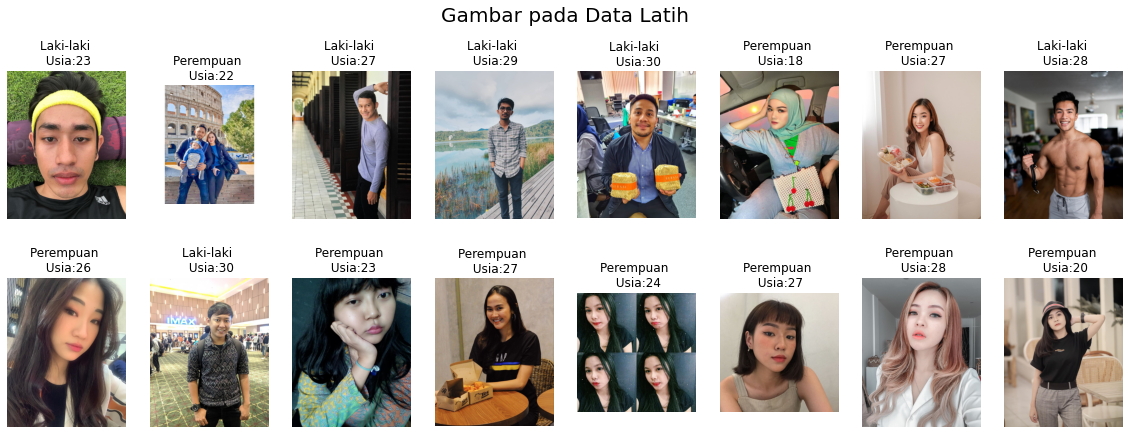

In [ ]:
fig = plt.figure(figsize=(20, 7))
plt.title('Gambar pada Data Latih', fontsize=20,y=1.08)
plt.axis('off')
columns = 8
rows = 2
img2show = data.sample(columns*rows)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    img = mpimg.imread(img2show.iloc[i-1]['image path'])
    jenis_kelamin = img2show.iloc[i-1]['Gender label']
    usia = img2show.iloc[i-1]['usia']
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.title(f'{jenis_kelamin} \n Usia:{usia}')

plt.show()

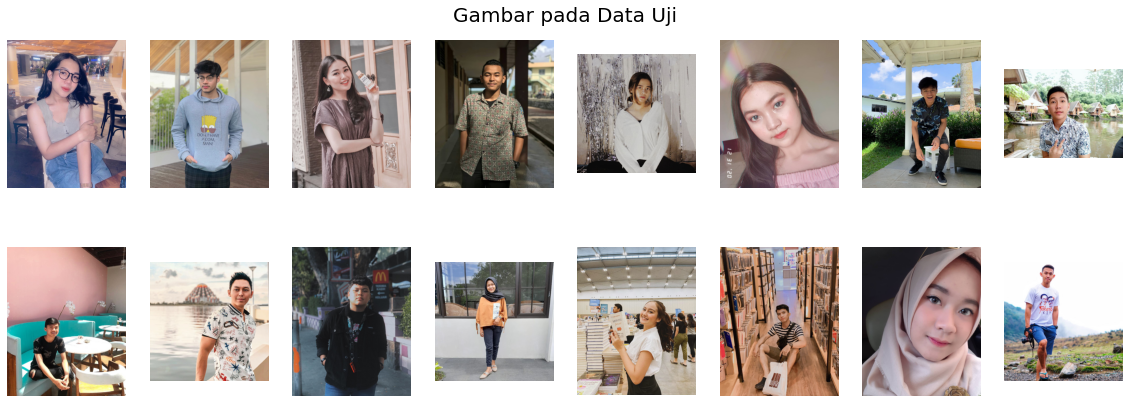

In [ ]:
from random import sample

fig = plt.figure(figsize=(20, 7))
plt.title('Gambar pada Data Uji', fontsize=20)
plt.axis('off')
columns = 8
rows = 2
img2show_t =  sample([testing_path + "/" + f for f in os.listdir(testing_path)],rows*columns)
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    img = mpimg.imread(img2show_t[i-1])
    imgplot = plt.imshow(img)
    plt.axis('off')
plt.show()

## Data Preprocessing

In [ ]:
def sudut_mata_center(arr1,arr2):
    #arr1 = mata kiri
    #arr2 = mata kanan

    from math import acos, pi, sqrt
    from shapely.geometry import Polygon

    def get_center(arr):
        c = Polygon(arr).centroid.coords.xy
        return [c[0][0],c[1][0]]

    p1 = get_center(arr1)
    p2 = get_center(arr2)

    a = abs(p1[0] - p2[0])
    b = abs(p1[1] - p2[1])
    c = sqrt(a**2+b**2)
    cos_A = a/c
    angle = acos(cos_A)
    return (angle * 180) / pi



def crop_face(filepath):
    """
    Parameters
    ----------
    filepath : path
        Path gambar yang akan di crop di bagian wajah

    Return
    -------
        Gambar yang sudah di crop di bagian wajah.
    """
    image = face_recognition.load_image_file(f)

    face_locations = face_recognition.face_locations(image)
    face_landmarks_list = face_recognition.face_landmarks(image)

    try:
        angle1 = -5
        angle2 = 5
        i = 0
        angle_plus = 0
        while (len(face_locations) == 0 or len(face_landmarks_list)==0 or (len(face_landmarks_list) != len(face_locations))) and (face_landmarks_list[0]['left_eye'][0][1] == face_landmarks_list[0]['right_eye'][0][1]) :
          if i%2 ==0:
              image = Image.open(filepath)
              image = image.rotate(angle1)
              image = np.asarray(image)
              face_locations = face_recognition.face_locations(image,model="cnn")
              face_landmarks_list = face_recognition.face_landmarks(image)

              if angle1 == -90:
                    return image
              
              angle1 -= 5
              angle_plus = angle1
          else:
              image = Image.open(filepath)
              image = image.rotate(angle2)
              image = np.asarray(image)
              face_locations = face_recognition.face_locations(image,model="cnn")
              face_landmarks_list = face_recognition.face_landmarks(image)

              if angle2 == 90:
                    return image
              
              angle2 += 5
              angle_plus = angle2

    except:
        angle = -90
        angle_plus = 0
        while len(face_locations) == 0 or len(face_landmarks_list)==0 or (len(face_landmarks_list) != len(face_locations)) or (face_landmarks_list[0]['left_eye'][0][1] == face_landmarks_list[0]['right_eye'][0][1]) :
           image = Image.open(filepath)
           image = image.rotate(angle)
           image = np.asarray(image)
           face_locations = face_recognition.face_locations(image,model="cnn")
           face_landmarks_list = face_recognition.face_landmarks(image)

           if angle == 90:
              return image
                  
           angle += 5
           angle_plus = angle

    if len(face_locations) == 0:
      return Image.fromarray(image)

    

    pil_image = []
    luas = []
    try:
      for face_location in face_locations:
          top, right, bottom, left = face_location
          luas = luas + [abs(top-bottom)*abs(right-left)]
          plus = int(0.2*abs(top-bottom))
          if left <= plus:
            face_image = image[top-plus:bottom+plus, 0:right+plus]
          elif right <= plus:
            face_image = image[top-plus:bottom+plus, left-plus:right]
          elif top <= plus:
            face_image = image[0:bottom+plus, left-plus:right+plus]
          elif bottom <= plus:
            face_image = image[top-plus:bottom, left-plus:right+plus]
          else:
            face_image = image[top-plus:bottom+plus, left-plus:right+plus]
          pil_image = pil_image + [face_image]
    except:
        for face_location in face_locations:
          top, right, bottom, left = face_location
          luas = luas + [abs(top-bottom)*abs(right-left)]
          plus = 0
          if left <= plus:
            face_image = image[top-plus:bottom+plus, 0:right+plus]
          elif right <= plus:
            face_image = image[top-plus:bottom+plus, left-plus:right]
          elif top <= plus:
            face_image = image[0:bottom+plus, left-plus:right+plus]
          elif bottom <= plus:
            face_image = image[top-plus:bottom, left-plus:right+plus]
          else:
            face_image = image[top-plus:bottom+plus, left-plus:right+plus]
          pil_image = pil_image + [face_image]
    
  
    idx = luas.index(max(luas))

    if len(face_locations) > 1:
        sudut = sudut_mata_center(face_landmarks_list[idx]['left_eye'],
                                  face_landmarks_list[idx]['right_eye'])
        if face_landmarks_list[idx]['left_eye'][0][1] > face_landmarks_list[idx]['right_eye'][0][1]:
          sudut = - sudut
        else:
          sudut = sudut
    else:
        sudut = sudut_mata_center(face_landmarks_list[0]['left_eye'],
                                  face_landmarks_list[0]['right_eye'])
        if face_landmarks_list[0]['left_eye'][0][1] > face_landmarks_list[0]['right_eye'][0][1]:
          sudut = - sudut
        else:
          sudut = sudut
    
    
    image = Image.open(filepath)
    image = image.rotate(angle_plus+sudut)
    image = np.asarray(image)

    face_locations = face_recognition.face_locations(np.asarray(image),model="cnn")

        
    pil_image = []
    luas = []

    try:
      for face_location in face_locations:
          top, right, bottom, left = face_location
          luas = luas + [abs(top-bottom)*abs(right-left)]
          plus = int(0.2*abs(top-bottom))
          if left <= plus:
            face_image = image[top-plus:bottom+plus, 0:right+plus]
          elif right <= plus:
            face_image = image[top-plus:bottom+plus, left-plus:right]
          elif top <= plus:
            face_image = image[0:bottom+plus, left-plus:right+plus]
          elif bottom <= plus:
            face_image = image[top-plus:bottom, left-plus:right+plus]
          else:
            face_image = image[top-plus:bottom+plus, left-plus:right+plus]
          pil_image = pil_image + [face_image]
    except:
        for face_location in face_locations:
          top, right, bottom, left = face_location
          luas = luas + [abs(top-bottom)*abs(right-left)]
          plus = 0
          if left <= plus:
            face_image = image[top-plus:bottom+plus, 0:right+plus]
          elif right <= plus:
            face_image = image[top-plus:bottom+plus, left-plus:right]
          elif top <= plus:
            face_image = image[0:bottom+plus, left-plus:right+plus]
          elif bottom <= plus:
            face_image = image[top-plus:bottom, left-plus:right+plus]
          else:
            face_image = image[top-plus:bottom+plus, left-plus:right+plus]

          pil_image = pil_image + [face_image]

    idx = luas.index(max(luas))
    img = Image.fromarray(pil_image[idx])
    return img

    
def crop_face2(filepath):
    """ Sama seperti fungsi crop_face, hanya saja menggunakan model="CNN" untuk mendeteksi wajah,
        membutuhkan waktut komputasi lebih lama, sehingga digunakan jika fungsi crop_face gagal
        mendeteksi wajah.
        
    Parameters
    ----------
    filepath : path
        Path gambar yang akan di crop di bagian wajah

    Return
    -------
        Gambar yang sudah di crop di bagian wajah.
    """

    image = face_recognition.load_image_file(f)

    face_locations = face_recognition.face_locations(image,model="cnn")
    face_landmarks_list = face_recognition.face_landmarks(image)

    try:
        angle1 = -5
        angle2 = 5
        i = 0
        angle_plus = 0
        while (len(face_locations) == 0 or len(face_landmarks_list)==0 or (len(face_landmarks_list) != len(face_locations))) and (face_landmarks_list[0]['left_eye'][0][1] == face_landmarks_list[0]['right_eye'][0][1]) :
          if i%2 ==0:
              image = Image.open(filepath)
              image = image.rotate(angle1)
              image = np.asarray(image)
              face_locations = face_recognition.face_locations(image,model="cnn")
              face_landmarks_list = face_recognition.face_landmarks(image)

              if angle1 == -90:
                    return image
              
              angle1 -= 5
              angle_plus = angle1
          else:
              image = Image.open(filepath)
              image = image.rotate(angle2)
              image = np.asarray(image)
              face_locations = face_recognition.face_locations(image,model="cnn")
              face_landmarks_list = face_recognition.face_landmarks(image)

              if angle2 == 90:
                    return image
              
              angle2 += 5
              angle_plus = angle2

    except:
        angle = -90
        angle_plus = 0
        while len(face_locations) == 0 or len(face_landmarks_list)==0 or (len(face_landmarks_list) != len(face_locations)) or (face_landmarks_list[0]['left_eye'][0][1] == face_landmarks_list[0]['right_eye'][0][1]) :
           image = Image.open(filepath)
           image = image.rotate(angle)
           image = np.asarray(image)
           face_locations = face_recognition.face_locations(image,model="cnn")
           face_landmarks_list = face_recognition.face_landmarks(image)

           if angle == 90:
              return image
                  
           angle += 5
           angle_plus = angle

    if len(face_locations) == 0:
      return Image.fromarray(image)

    

    pil_image = []
    luas = []
    try:
      for face_location in face_locations:
          top, right, bottom, left = face_location
          luas = luas + [abs(top-bottom)*abs(right-left)]
          plus = int(0.2*abs(top-bottom))
          if left <= plus:
            face_image = image[top-plus:bottom+plus, 0:right+plus]
          elif right <= plus:
            face_image = image[top-plus:bottom+plus, left-plus:right]
          elif top <= plus:
            face_image = image[0:bottom+plus, left-plus:right+plus]
          elif bottom <= plus:
            face_image = image[top-plus:bottom, left-plus:right+plus]
          else:
            face_image = image[top-plus:bottom+plus, left-plus:right+plus]
          pil_image = pil_image + [face_image]
    except:
        for face_location in face_locations:
          top, right, bottom, left = face_location
          luas = luas + [abs(top-bottom)*abs(right-left)]
          plus = 0
          if left <= plus:
            face_image = image[top-plus:bottom+plus, 0:right+plus]
          elif right <= plus:
            face_image = image[top-plus:bottom+plus, left-plus:right]
          elif top <= plus:
            face_image = image[0:bottom+plus, left-plus:right+plus]
          elif bottom <= plus:
            face_image = image[top-plus:bottom, left-plus:right+plus]
          else:
            face_image = image[top-plus:bottom+plus, left-plus:right+plus]
          pil_image = pil_image + [face_image]
    
  
    idx = luas.index(max(luas))

    if len(face_locations) > 1:
        sudut = sudut_mata_center(face_landmarks_list[idx]['left_eye'],
                                  face_landmarks_list[idx]['right_eye'])
        if face_landmarks_list[idx]['left_eye'][0][1] > face_landmarks_list[idx]['right_eye'][0][1]:
          sudut = - sudut
        else:
          sudut = sudut
    else:
        sudut = sudut_mata_center(face_landmarks_list[0]['left_eye'],
                                  face_landmarks_list[0]['right_eye'])
        if face_landmarks_list[0]['left_eye'][0][1] > face_landmarks_list[0]['right_eye'][0][1]:
          sudut = - sudut
        else:
          sudut = sudut
    
    
    image = Image.open(filepath)
    image = image.rotate(angle_plus+sudut)
    image = np.asarray(image)

    face_locations = face_recognition.face_locations(np.asarray(image),model="cnn")

        
    pil_image = []
    luas = []

    try:
      for face_location in face_locations:
          top, right, bottom, left = face_location
          luas = luas + [abs(top-bottom)*abs(right-left)]
          plus = int(0.2*abs(top-bottom))
          if left <= plus:
            face_image = image[top-plus:bottom+plus, 0:right+plus]
          elif right <= plus:
            face_image = image[top-plus:bottom+plus, left-plus:right]
          elif top <= plus:
            face_image = image[0:bottom+plus, left-plus:right+plus]
          elif bottom <= plus:
            face_image = image[top-plus:bottom, left-plus:right+plus]
          else:
            face_image = image[top-plus:bottom+plus, left-plus:right+plus]
          pil_image = pil_image + [face_image]
    except:
        for face_location in face_locations:
          top, right, bottom, left = face_location
          luas = luas + [abs(top-bottom)*abs(right-left)]
          plus = 0
          if left <= plus:
            face_image = image[top-plus:bottom+plus, 0:right+plus]
          elif right <= plus:
            face_image = image[top-plus:bottom+plus, left-plus:right]
          elif top <= plus:
            face_image = image[0:bottom+plus, left-plus:right+plus]
          elif bottom <= plus:
            face_image = image[top-plus:bottom, left-plus:right+plus]
          else:
            face_image = image[top-plus:bottom+plus, left-plus:right+plus]
          

          pil_image = pil_image + [face_image]
       
    idx = luas.index(max(luas))

    img = Image.fromarray(pil_image[idx])
    return img

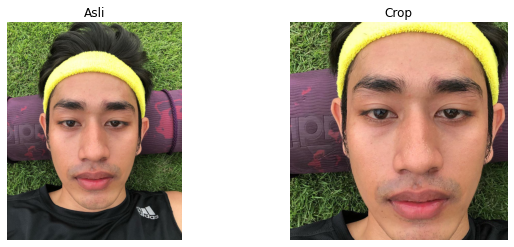

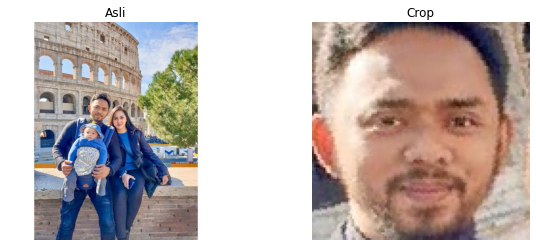

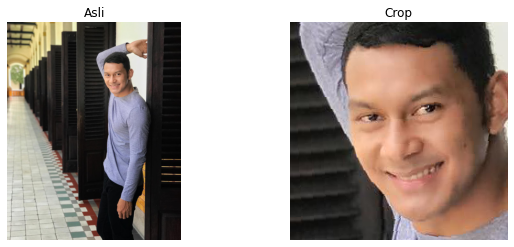

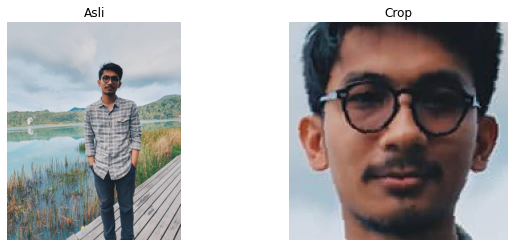

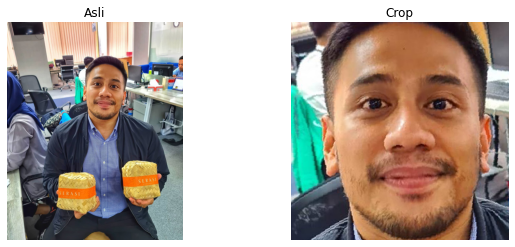

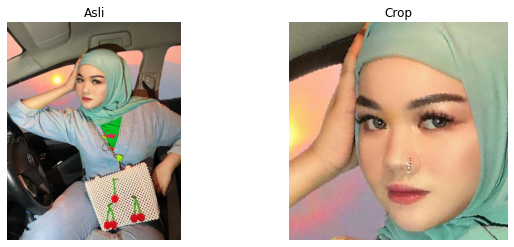

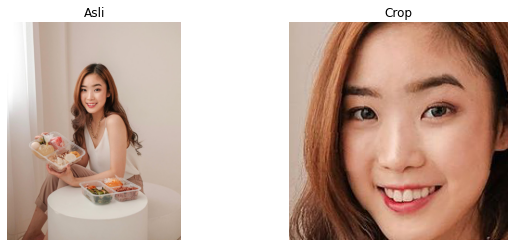

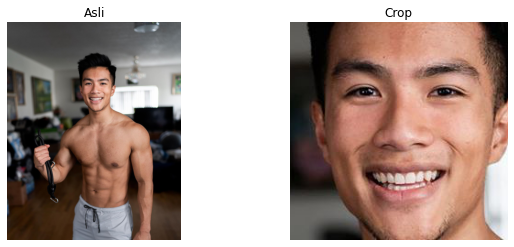

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg

for f in data.sample(8)['image path']:
    fig = plt.figure(figsize=(10, 4))
    gs = GridSpec(nrows=1, ncols=2)

    ax0 = fig.add_subplot(gs[0, 0])
    img1 = mpimg.imread(f)
    imgplot = plt.imshow(img1)
    plt.axis('off')
    plt.title('Asli')
    

    ax1 = fig.add_subplot(gs[0, 1])
    try:
      img = crop_face(f)
    except:
      try:
        img = crop_face2(f)
      except:
        img = mpimg.imread(f)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.title('Crop')
    plt.show()    

In [ ]:
data['image path baru'] = np.nan
data.head()

image path  ...  image path baru
0  /content/drive/MyDrive/DataBDC/Training/96/96_...  ...              NaN
1  /content/drive/MyDrive/DataBDC/Training/96/96_...  ...              NaN
2  /content/drive/MyDrive/DataBDC/Training/96/96_...  ...              NaN
3  /content/drive/MyDrive/DataBDC/Training/92/92_...  ...              NaN
4  /content/drive/MyDrive/DataBDC/Training/92/92_...  ...              NaN

[5 rows x 5 columns]

In [ ]:
i = 0
for f in tqdm(data['image path']):
    try:
        img = crop_face(f)
        img.save("/content/drive/MyDrive/DataBDC/data fix/Crop + rotation 20%/"+os.path.basename(f))
        data.iloc[i,4] = "/content/drive/MyDrive/DataBDC/data fix/Crop + rotation 20%/"+os.path.basename(f)
    except:
      try:
        img = crop_face2(f)
        img.save("/content/drive/MyDrive/DataBDC/data fix/Crop + rotation 20%/"+os.path.basename(f))
        data.iloc[i,4] = "/content/drive/MyDrive/DataBDC/data fix/Crop + rotation 20%/"+os.path.basename(f)
      except:
        image = Image.open(f)
        image.save("/content/drive/MyDrive/DataBDC/data fix/Crop + rotation 20%/"+os.path.basename(f))
        data.iloc[i,4] = "/content/drive/MyDrive/DataBDC/data fix/Crop + rotation 20%/"+os.path.basename(f)
    i += 1

100%|██████████| 2310/2310 [00:03<00:00, 731.42it/s]


In [ ]:
data.head()

image path  ...                                    image path baru
0  /content/drive/MyDrive/DataBDC/Training/96/96_...  ...  /content/drive/MyDrive/DataBDC/data fix/Crop +...
1  /content/drive/MyDrive/DataBDC/Training/96/96_...  ...  /content/drive/MyDrive/DataBDC/data fix/Crop +...
2  /content/drive/MyDrive/DataBDC/Training/96/96_...  ...  /content/drive/MyDrive/DataBDC/data fix/Crop +...
3  /content/drive/MyDrive/DataBDC/Training/92/92_...  ...  /content/drive/MyDrive/DataBDC/data fix/Crop +...
4  /content/drive/MyDrive/DataBDC/Training/92/92_...  ...  /content/drive/MyDrive/DataBDC/data fix/Crop +...

[5 rows x 5 columns]

In [ ]:
data.to_csv('/content/drive/MyDrive/DataBDC/train_data_fix.csv',index=False)

## Data Splitting

In [ ]:
### 80% train -- 10% val -- 10% test ###

def split_data(df):
    from sklearn.model_selection import StratifiedShuffleSplit

    Split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=1234)
    Split2 = StratifiedShuffleSplit(n_splits=1, test_size=1/9, random_state=1234)

    for train_index, test_index in Split1.split(df.loc[:, df.columns!='usia'], df['usia']): 
        X = df.loc[:, df.columns!='usia']
        y = df['usia']
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    for train_index, val_index in Split2.split(X_train, y_train):   
        X = X_train
        y = y_train
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index] 

    return X_train, X_val, X_test, y_train, y_val, y_test


def plot_data(df,title):
    fig = plt.figure(figsize=(15, 6))
    st = fig.suptitle(title, fontsize=20, y=0.6)
    gs = GridSpec(nrows=2, ncols=2)

    ax0 = fig.add_subplot(gs[0, 0])
    sns.histplot(data=df, x="usia",kde=True,bins=len(df['usia'].unique()))

    ax1 = fig.add_subplot(gs[:, 1])
    colors = ['tab:blue', 'tab:orange']
    plt.pie(df['Gender label'].value_counts(), labels=data['Gender label'].value_counts().index, autopct="%1.0f%%", textprops=dict(size=14), startangle=90, explode=tuple([0.05] * 2), colors=colors)
    plt.axis("off")

    ax2 = fig.add_subplot(gs[1, 0])
    sns.histplot(data=df, x="usia", hue='Gender label',kde=True,bins=len(df['usia'].unique()),hue_order = ["Perempuan", "Laki-laki"],multiple="stack")

    st.set_y(0.95)

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data)  

train = pd.concat([X_train, y_train.to_frame()],axis=1)
val = pd.concat([X_val, y_val.to_frame()],axis=1)
test = pd.concat([X_test, y_test.to_frame()],axis=1)

print('Train shape      :', train.shape)
print('Validation shape :', val.shape)
print('Test shape       :', test.shape)

Train shape      : (1848, 8)
Validation shape : (231, 8)
Test shape       : (231, 8)


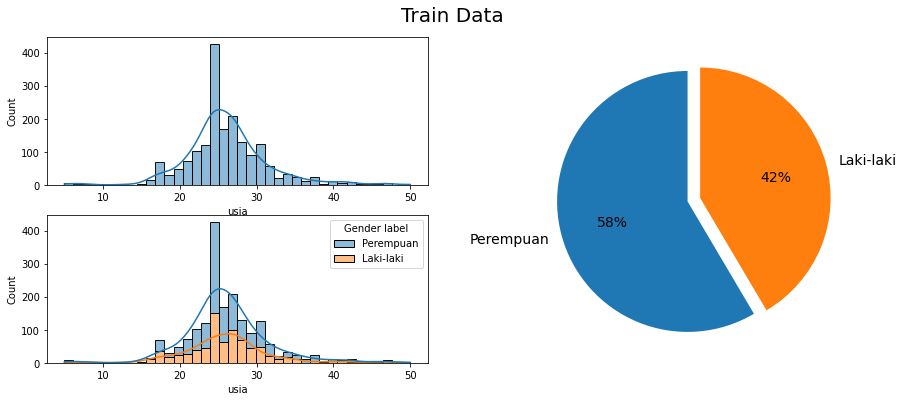

In [ ]:
plot_data(train,'Train Data')

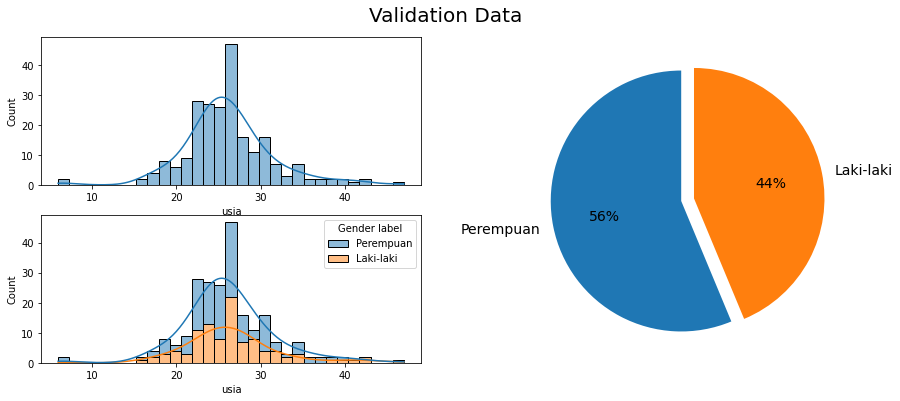

In [ ]:
plot_data(val,'Validation Data')

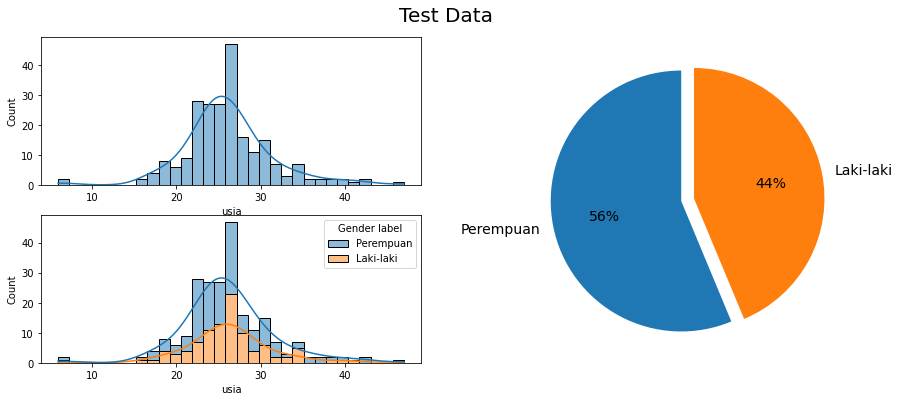

In [ ]:
plot_data(test, 'Test Data')

## Baseline

In [ ]:
def baseline(y_train,y_test):
    from sklearn.metrics import mean_squared_error
    """Menghitung MSE dengan menggunakan usia rata-rata pada data latih.

    Parameter
    ----------
    y_test : pd.DataFrame, pd.Series
        label pada data test 
    y_train : pd.DataFrame, pd.Series
        label pada data train

    Return
    -------
    float
        MSE.
    """
    y_hat = round(y_train.mean())

    mse = mean_squared_error(y_test, [y_hat]*len(y_test))

    return mse

In [ ]:
baseline = baseline(y_train, y_test)

print("baseline MSE: ", baseline)

baseline MSE:  32.073593073593074


## Modeling

In [ ]:
img_size = 224

def create_generators(train, val, test):
    """
    Parameters
    ----------
    train : pd.DataFrame
        Data latih
    val : pd.DataFrame
        Data validasi
    test : pd.DataFrame
        Data uji

    Return
    -------
    Iterator, Iterator, Iterator
        keras ImageDataGenerators untuk training, validating and testing model.
    """


    train_generator = ImageDataGenerator(rotation_range=10,
                                         zoom_range=0.1,
                                         horizontal_flip=True,
                                         rescale=(1/255),
                                         brightness_range=[0.4,1.5],
                                         width_shift_range=0.2, 
                                         height_shift_range=0.2)  
    
    validation_generator = ImageDataGenerator()  
    
    test_generator = ImageDataGenerator()

    train_generator = train_generator.flow_from_dataframe(dataframe=train,
                                                          x_col="image path baru",  
                                                          y_col="usia",  
                                                          class_mode="raw",  
                                                          color_mode = "rgb",
                                                          target_size=(img_size, img_size),
                                                          batch_size= 1,
                                                          seed = 1337)

    validation_generator = validation_generator.flow_from_dataframe(dataframe=val,
                                                                    x_col="image path baru",
                                                                    y_col="usia",
                                                                    class_mode="raw",
                                                                    target_size=(img_size, img_size),
                                                                    color_mode = "rgb",
                                                                    batch_size=32,
                                                                    seed = 1337)
    
    test_generator = test_generator.flow_from_dataframe(dataframe=test,
                                                        x_col="image path baru",
                                                        y_col="usia",
                                                        class_mode="raw",
                                                        target_size=(img_size, img_size),
                                                        color_mode = "rgb",
                                                        batch_size=32,
                                                        seed = 1337)
    return train_generator, validation_generator, test_generator

In [ ]:
train_generator, validation_generator, test_generator = create_generators(train, val, test) 

Found 1848 validated image filenames.
Found 231 validated image filenames.
Found 231 validated image filenames.


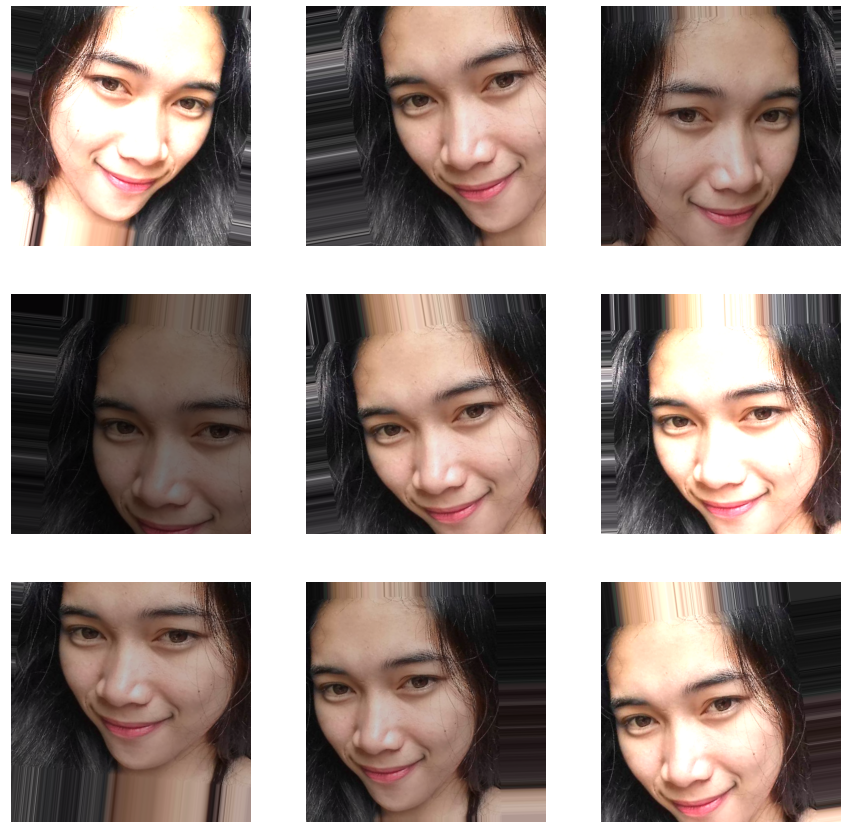

In [ ]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('/content/367_1.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(            rotation_range=10,
                                         zoom_range=0.1,
                                         horizontal_flip=True,
                                         brightness_range=[0.4,1.5],
                                         width_shift_range=0.2, 
                                         height_shift_range=0.2
                             )
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot


fig = plt.figure(figsize=(15, 15))
plt.axis('off')
columns = 3
rows = 3

for i in range(1, columns*rows +1):
    batch = it.next()

    image = batch[0].astype('uint8')

    fig.add_subplot(rows, columns, i)
    imgplot = plt.imshow(image)
    
    plt.axis('off')
plt.show()



In [ ]:
def get_callbacks(model_name: str):
    """
    Parameters
    ----------
    model_name : str
        Nama model yang digunakan.

    Return
    -------
        list keras callbacks [checkpoint, LearningRateScheduler]
    """

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(model_name + "-weights-improvement-{epoch:04d}-{val_mean_squared_error:.5f}.hdf5",
                                                                   monitor="val_mean_squared_error",
                                                                   verbose=1,
                                                                   save_best_only=True,  
                                                                   mode="min")  
    
    def scheduler(epoch, lr):
      if epoch <= 60:
        return lr 
      else:
        return lr * tf.math.exp(-0.1)

    
    return [model_checkpoint_callback,  keras.callbacks.LearningRateScheduler(scheduler, verbose=1)]

In [ ]:
from tensorflow.keras.losses import MeanSquaredError
import tensorflow_addons as tfa
from keras.models import load_model

def run_model(model_name: str, model_function: Model,train_generator, validation_generator,test_generator):
    """Fungsi ini untuk menjalankan model dengan Ranger optimizer dan beberapa callbacks. 

    Parameters
    ----------
    model_name : str
        Nama model
    model_function : Model
        fungsi untuk memperoleh model, seperti get_model() atau make_model()
    train_generator : Iterator
        keras ImageDataGenerators untuk data train
    validation_generator : Iterator
        keras ImageDataGenerators untuk data validasi

    Return
    -------
    History
        history dari keras model, untuk mengaksesnya sebagai dictionary, gunakan history.history.
    """

    callbacks = get_callbacks(model_name)
    model = model_function
    model.summary()

    radam = tfa.optimizers.RectifiedAdam(learning_rate=0.001)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    optimizer = ranger

    model.compile(
        optimizer=optimizer, loss="mse",metrics=[tf.keras.metrics.MeanSquaredError()]
    )

    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    return history 


In [ ]:
## Ini diset
layer1 = 64              
layer2= 32               
layer3 = 1024          

IMG_SHAPE = (img_size,img_size,3)

def make_model(layer1, layer2, layer3, input_shape):
   """
    parameters
    layer1, layer2, layer3 : int
      size pada Conv2D layer
    input_shape
      image shape yang akan di proses
    Returns
    -------
    Model
        Keras model
    """
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(layer1, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(layer2, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add residual
        previous_block_activation = x  # Set residual

    x = layers.SeparableConv2D(layer3, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu')(x)
    outputs = layers.Dense(1, activation='relu')(x)
    return keras.Model(inputs, outputs)


In [ ]:
def get_model(model,input_shape):
    """
    parameters
    model
      keras.aplication model
    input_shape
      image shape yang akan di proses
    Returns
    -------
    Model
        Keras model
    """
    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = model(include_top=False,weights=None)(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='relu')(x)

    return  keras.Model(inputs, outputs)


### Run Model

In [ ]:
tf.keras.backend.clear_session()
try:
    del model
    tf.keras.backend.clear_session()
except:
    print('Tidak ada model sebelumnya')

input_shape = (img_size,img_size,3)

model_name = 'MobileNetV2'                            
model = tf.keras.applications.MobileNetV2          

history_MobileNetV2 = run_model(model_name=model_name, 
                    model_function=get_model(model,input_shape),
                    train_generator=train_generator,
                    validation_generator=validation_generator,
                    test_generator=test_generator)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_None (Funct (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984 

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
58/58 [==============================] - 31s 539ms/step - loss: 154.8566 - mean_squared_error: 154.8566 - val_loss: 311.3070 - val_mean_squared_error: 311.3070

Epoch 00002: val_mean_squared_error improved from 520.89142 to 311.30698, saving model to MobileNetV2-weights-improvement-0002-311.30698.hdf5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
58/58 [==============================] - 32s 542ms/step - loss: 55.5711 - mean_squared_error: 55.5711 - val_loss: 209.4690 - val_mean_squared_error: 209.4690

Epoch 00003: val_mean_squared_error improved from 311.30698 to 209.46899, saving model to MobileNetV2-weights-improvement-0003-209.46899.hdf5
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
58/58 [==============================] - 31s 540ms/step - loss: 37.2879 - mean_squared_error: 37.2879 - val_

In [ ]:
model_name = 'Model48'                                    

history_Model48 = run_model(model_name=model_name, 
                    model_function=make_model(64,32,1024,input_shape),
                    train_generator=train_generator,
                    validation_generator=validation_generator,
                    test_generator=test_generator)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 1792        rescaling_1[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 64) 256         conv2d[0][0]                     
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
58/58 [==============================] - 33s 568ms/step - loss: 30.7273 - mean_squared_error: 30.7273 - val_loss: 607.0326 - val_mean_squared_error: 607.0326

Epoch 00002: val_mean_squared_error improved from 653.80316 to 607.03259, saving model to Model48-weights-improvement-0002-607.03259.hdf5
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
58/58 [==============================] - 33s 568ms/step - loss: 30.0792 - mean_squared_error: 30.0792 - val_loss: 549.5964 - val_mean_squared_error: 549.5964

Epoch 00003: val_mean_squared_error improved from 607.03259 to 549.59637, saving model to Model48-weights-improvement-0003-549.59637.hdf5
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0010000000474974513.
58/58 [==============================] - 33s 567ms/step - loss: 30.5919 - mean_squared_error: 30.5919 - val_loss: 494.

In [ ]:
def plot_results(history_MobileNetV2, history_Model48, mean_baseline):

    dict1 = {
        "MSE": history_MobileNetV2.history["mean_squared_error"],
        "type": "training",
        "model": "MobileNetV2",
    }
    dict2 = {
        "MSE": history_MobileNetV2.history["val_mean_squared_error"],
        "type": "validation",
        "model": "MobileNetV2",
    }
    dict3 = {
        "MSE": history_Model48.history["mean_squared_error"],
        "type": "training",
        "model": "Model 48",
    }
    dict4 = {
        "MSE": history_Model48.history["val_mean_squared_error"],
        "type": "validation",
        "model": "Model 48",
    }

    
    s1 = pd.DataFrame(dict1)
    s2 = pd.DataFrame(dict2)
    s3 = pd.DataFrame(dict3)
    s4 = pd.DataFrame(dict4)
    df = pd.concat([s1, s2, s3, s4], axis=0).reset_index()
    grid = sns.relplot(data=df, x=df["index"], y="MSE", hue="model", col="type", kind="line", legend=False)
    grid.set(ylim=(20, 100))  
    for ax in grid.axes.flat:
        ax.axhline(
            y=mean_baseline, color="lightcoral", linestyle="dashed"
        )  
        ax.set(xlabel="Epoch")
    labels = ["MobileNetV2", "model 48", "mean_baseline"] 

    plt.legend(labels=labels)
    plt.show()

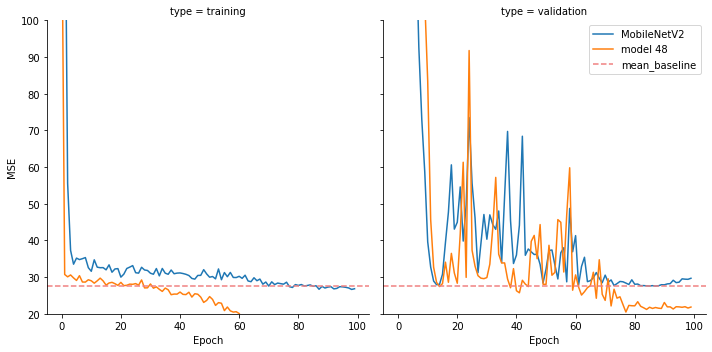

In [ ]:
plot_results(history_MobileNetV2, history_Model48, baseline)

### Evaluasi Model

In [ ]:
from tqdm import tqdm
import numpy as np
from tqdm import tqdm

def img_preprocessing(img_path):

    img = Image.open(img_path)


    img = img.resize((224,224))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  
    return img_array


def make_prediction(model,testing_path):
    from tqdm import tqdm
    predictions = np.array([])
    for i in tqdm(testing_path):
        predictions = np.append(predictions, [model.predict(img_preprocessing(i))]) 

    return predictions
  

In [ ]:
MobileNetV2 = load_model('/content/MobileNetV2-weights-improvement-0088-27.58283.hdf5')
Model48 = load_model('/content/Model48-weights-improvement-0078-20.48330.hdf5')

MobileNetV2.save('/content/drive/MyDrive/DataBDC/MobileNetV2-weights-improvement-0088-27.58283.hdf5')
Model48 .save('/content/drive/MyDrive/DataBDC/Model48-weights-improvement-0078-20.48330.hdf5')

M = [MobileNetV2, Model48]
MM = ['MobileNetV2', 'Model48']

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
yhat = {}

i = 0
for m in M:
  yhat[MM[i]] = make_prediction(m,test['image path baru'])
  i += 1

100%|██████████| 231/231 [00:10<00:00, 22.58it/s]


In [ ]:
print('MSE MobileNetV2 :' , mean_squared_error(y_test,np.round(yhat['MobileNetV2'])))
print('MSE Model48     :' , mean_squared_error(y_test,np.round(yhat['Model48'])))

MSE MobileNetV2 : 27.606060606060606
MSE Model48     : 19.658008658008658


In [ ]:
yhat_mix = (yhat['MobileNetV2']  + yhat['Model48'])/2
yhat_mix_round = np.round(yhat_mix)

mse = mean_squared_error(y_test,yhat_mix_round)
mse_float = mean_squared_error(y_test,yhat_mix)
mae = mean_absolute_error(y_test,yhat_mix_round)
mae_float = mean_absolute_error(y_test,yhat_mix)

print('MSE rounded  :', mse)
print('MSE          :', mse_float)
print('MAE rounded  :', mae)
print('MAE          :', mae_float)

MSE rounded  : 20.896103896103895
MSE          : 20.408547791744546
MAE rounded  : 3.303030303030303
MAE          : 3.2980386519328855


In [ ]:
from keras.models import load_model

model1 = load_model('/content/drive/MyDrive/DataBDC/Model_24_1024_1024_seed-weights-improvement-0128-19.55515.hdf5',compile=False)
model2 = load_model('/content/drive/MyDrive/DataBDC/Model_o48_400Epoch_1024_1024_seed-weights-improvement-0246-19.91030.hdf5',compile=False)
model3 = load_model('/content/drive/MyDrive/DataBDC/Model_o48_400Epoch_1024_1024_seed-weights-improvement-0246-19.91030.hdf5',compile=False)
model4 = load_model('/content/drive/MyDrive/DataBDC/Model_ok_1024_1024_seed-weights-improvement-0141-20.35686.hdf5',compile=False)
model5 = load_model('/content/drive/MyDrive/DataBDC/Model_ok_1024_1024_seed-weights-improvement-0170-21.07264.hdf5',compile=False)
model6 = load_model('/content/drive/MyDrive/DataBDC/model_ok_1024-1-weights-improvement-0065-22.66626.hdf5',compile=False)
model7 = load_model('/content/drive/MyDrive/DataBDC/Model48-weights-improvement-0078-20.48330.hdf5',compile=False)

M = [model1, model2, model3, model4, model5, model6, model7]
MM = ['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7']

In [ ]:
yhat = {}

i = 0
for m in M:
  yhat[MM[i]] = make_prediction(m,test['image path baru'])
  i += 1

100%|██████████| 231/231 [00:11<00:00, 20.04it/s]


In [ ]:
print('Model 1 :' , mean_squared_error(y_test,np.round(yhat['model1'])))
print('Model 2 :' , mean_squared_error(y_test,np.round(yhat['model2'])))
print('Model 3 :' , mean_squared_error(y_test,np.round(yhat['model3'])))
print('Model 4 :' , mean_squared_error(y_test,np.round(yhat['model4'])))
print('Model 5 :' , mean_squared_error(y_test,np.round(yhat['model5'])))
print('Model 6 :' , mean_squared_error(y_test,np.round(yhat['model6'])))
print('Model 7 :' , mean_squared_error(y_test,np.round(yhat['model7'])))

Model 1 : 19.51082251082251
Model 2 : 19.67099567099567
Model 3 : 19.67099567099567
Model 4 : 19.584415584415584
Model 5 : 21.051948051948052
Model 6 : 19.636363636363637
Model 7 : 11.727272727272727


In [ ]:
yhat_mix = (yhat['model1']  + yhat['model2'] + yhat['model4'] + yhat['model4'] + yhat['model5'] + yhat['model6'] + yhat['model7'])/7
yhat_mix_round = np.round(yhat_mix)

mse = mean_squared_error(y_test,yhat_mix_round)
mse_float = mean_squared_error(y_test,yhat_mix)
mae = mean_absolute_error(y_test,yhat_mix_round)
mae_float = mean_absolute_error(y_test,yhat_mix)

print('MSE rounded  :', mse)
print('MSE          :', mse_float)
print('MAE rounded  :', mae)
print('MAE          :', mae_float)

MSE rounded  : 15.363636363636363
MSE          : 15.263814843009138
MAE rounded  : 2.9047619047619047
MAE          : 2.8976897131755313


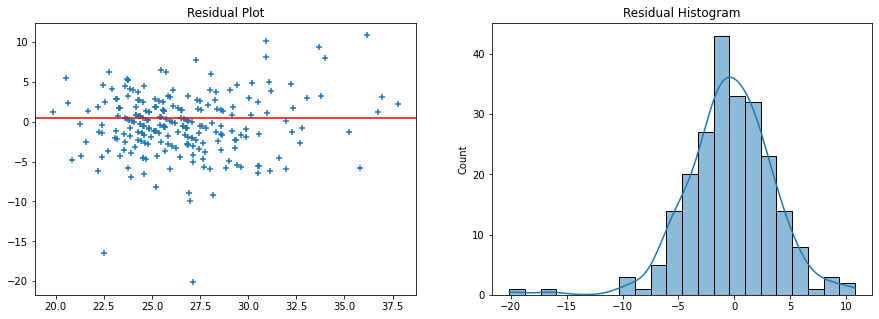

In [ ]:
import matplotlib.pyplot as plt
resid = y_test.to_numpy() - yhat_mix

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.scatter(yhat_mix,resid, marker='+')
plt.title('Residual Plot')

plt.subplot(1, 2, 2)
sns.histplot(resid,kde=True)
plt.title('Residual Histogram')
plt.show()

In [ ]:
jelek = test.loc[abs(resid) >=5]
jelek['prediksi'] = yhat_mix[abs(resid) >= 5]
jelek['error'] = abs(jelek['usia']-jelek['prediksi'])
jelek = jelek.sort_values(by=['error'],ascending=False)
jelek.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


image path  ...      error
544   /content/drive/MyDrive/DataBDC/Training/629/62...  ...  20.144100
622   /content/drive/MyDrive/DataBDC/Training/606/60...  ...  16.498031
1919  /content/drive/MyDrive/DataBDC/Training/218/21...  ...  10.810853
1253  /content/drive/MyDrive/DataBDC/Training/42/42_...  ...  10.060751
95    /content/drive/MyDrive/DataBDC/Training/76/76_...  ...   9.970807

[5 rows x 10 columns]

In [ ]:
bagus = test.loc[np.round(resid)==0]
bagus['prediksi'] = yhat_mix[np.round(resid)==0]
bagus.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


image path  ...   prediksi
926   /content/drive/MyDrive/DataBDC/Training/52/52_...  ...  25.938726
2185  /content/drive/MyDrive/DataBDC/Training/140/14...  ...  21.240011
1231  /content/drive/MyDrive/DataBDC/Training/422/42...  ...  25.435771
1180  /content/drive/MyDrive/DataBDC/Training/432/43...  ...  27.065217
1000  /content/drive/MyDrive/DataBDC/Training/489/48...  ...  23.817728

[5 rows x 9 columns]

In [ ]:
sedang = test.loc[(np.round(resid)>0) & (np.round(resid)<4) ]
sedang['prediksi'] = yhat_mix[(np.round(resid)>0) & (np.round(resid)<4) ]
sedang.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


image path  ...   prediksi
1408  /content/drive/MyDrive/DataBDC/Training/375/37...  ...  27.345060
2050  /content/drive/MyDrive/DataBDC/Training/172/17...  ...  23.279255
1524  /content/drive/MyDrive/DataBDC/Training/333/33...  ...  26.076864
789   /content/drive/MyDrive/DataBDC/Training/558/55...  ...  23.317577
1852  /content/drive/MyDrive/DataBDC/Training/239/23...  ...  36.931894

[5 rows x 9 columns]

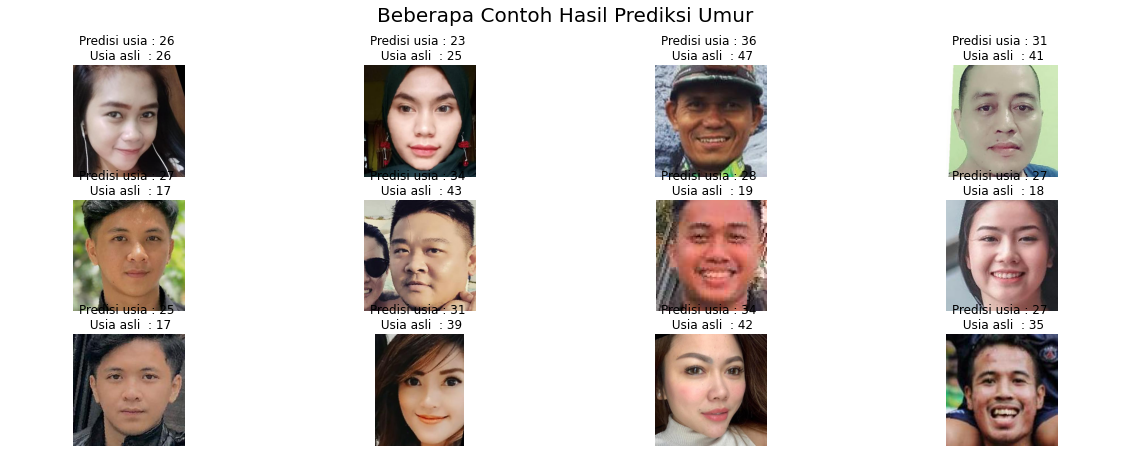

In [ ]:
%matplotlib inline
import matplotlib.image as mpimg


fig = plt.figure(figsize=(20, 7))
plt.title('Beberapa Contoh Hasil Prediksi Umur',y=1.1, fontsize=20)
plt.axis('off')
columns = 4
rows = 3

r = 1

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    if r ==1:
        img = mpimg.imread(bagus.iloc[i-1]['image path baru'])
        prediksi = bagus.iloc[i-1]['prediksi']
        usia = bagus.iloc[i-1]['usia']
    elif r==2:
        img = mpimg.imread(sedang.iloc[i-1]['image path baru'])
        prediksi = sedang.iloc[i-1]['prediksi']
        usia = sedang.iloc[i-1]['usia']
    else:
        img = mpimg.imread(jelek.iloc[i-1]['image path baru'])
        prediksi = jelek.iloc[i-1]['prediksi']
        usia = jelek.iloc[i-1]['usia']
    
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predisi usia : {round(prediksi)} \n Usia asli  : {usia}')
    r +=1
plt.show()


In [ ]:
bagus = test.loc[np.round(resid)==0]
bagus['prediksi'] = yhat_mix[np.round(resid)==0]
bagus.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


image path  ...   prediksi
926   /content/drive/MyDrive/DataBDC/Training/52/52_...  ...  25.938726
2185  /content/drive/MyDrive/DataBDC/Training/140/14...  ...  21.240011
1231  /content/drive/MyDrive/DataBDC/Training/422/42...  ...  25.435771
1180  /content/drive/MyDrive/DataBDC/Training/432/43...  ...  27.065217
1000  /content/drive/MyDrive/DataBDC/Training/489/48...  ...  23.817728

[5 rows x 9 columns]

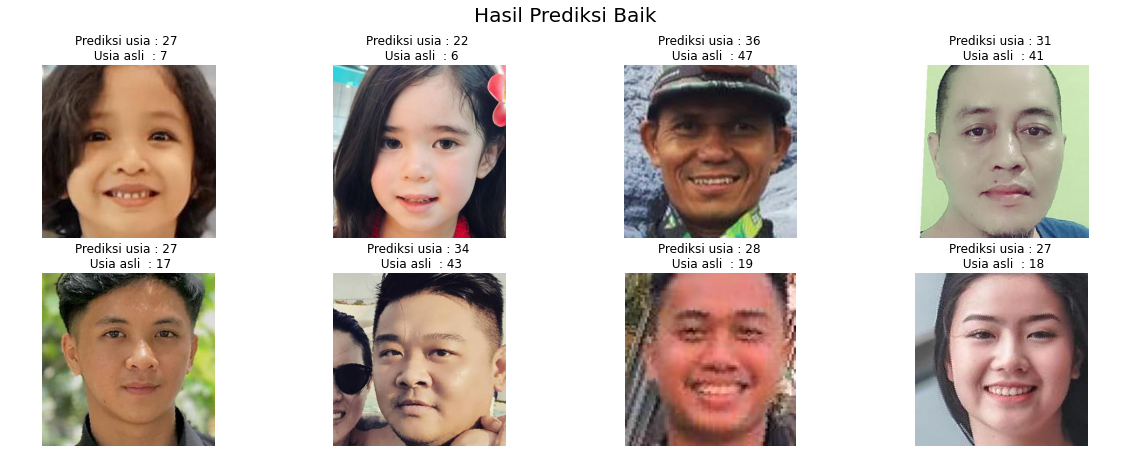

In [ ]:
fig = plt.figure(figsize=(20, 7))
plt.title('Hasil Prediksi Baik',y=1.1, fontsize=20)
plt.axis('off')
columns = 4
rows = 2

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    img = mpimg.imread(jelek.iloc[i-1]['image path baru'])
    prediksi = jelek.iloc[i-1]['prediksi']
    usia = jelek.iloc[i-1]['usia']
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediksi usia : {round(prediksi)} \n Usia asli  : {usia}')
plt.show()

## Prediksi

In [ ]:
from keras.models import load_model

model1 = load_model('/content/drive/MyDrive/DataBDC/Model_1.hdf5',compile=False)
model2 = load_model('/content/drive/MyDrive/DataBDC/Model_2.hdf5',compile=False)
model3 = load_model('/content/drive/MyDrive/DataBDC/Model_3.hdf5',compile=False)
model4 = load_model('/content/drive/MyDrive/DataBDC/Model_4.hdf5',compile=False)
model5 = load_model('/content/drive/MyDrive/DataBDC/Model_5.hdf5',compile=False)
model6 = load_model('/content/drive/MyDrive/DataBDC/Model_6.hdf5',compile=False)
model7 = load_model('/content/drive/MyDrive/DataBDC/Model_7.hdf5',compile=False)

M = [model1, model2, model3, model4, model5, model6, model7]
MM = ['model1', 'model2', 'model3', 'model4', 'model5', 'model6', 'model7']

In [ ]:
image_name = !ls $testing_path

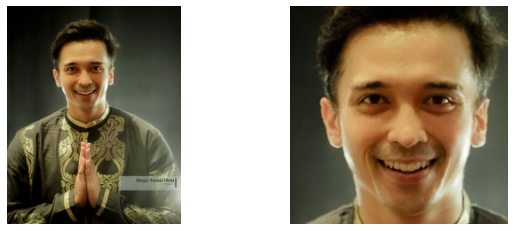

Prediksi umur model 1: 37.55566
Prediksi umur model 2: 32.415813
Prediksi umur model 3: 31.195288
Prediksi umur model 4: 29.21893
Prediksi umur model 5: 32.42305
Prediksi umur model 6: 28.636677
Prediksi umur model 7: 28.128155
Prediksi umur : 31


In [ ]:
image_size = (224, 224)

from random import randint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from skimage.transform import resize

i = randint(0,990)
f = testing_path + "/"+image_name[i]



fig = plt.figure(figsize=(10, 4))
gs = GridSpec(nrows=1, ncols=2)

ax0 = fig.add_subplot(gs[0, 0])
img1 = mpimg.imread(f)
imgplot = plt.imshow(img1)
plt.axis('off')
   

ax1 = fig.add_subplot(gs[0, 1])
try:
   img = crop_face(f)
except:
   try:
     img = crop_face2(f)
   except:
     img = mpimg.imread(f)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()    


img = img.resize(image_size)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions1 = model1.predict(img_array)
predictions2 = model2.predict(img_array)
predictions3 = model3.predict(img_array)
predictions4 = model4.predict(img_array)
predictions5 = model5.predict(img_array)
predictions6 = model6.predict(img_array)
predictions7 = model7.predict(img_array)
prediction_final = (predictions1[0][0]+predictions2[0][0]+predictions3[0][0]+predictions4[0][0]+predictions5[0][0]+predictions6[0][0]+predictions7[0][0])/7

print('Prediksi umur model 1:',predictions1[0][0])
print('Prediksi umur model 2:',predictions2[0][0])
print('Prediksi umur model 3:',predictions3[0][0])
print('Prediksi umur model 4:',predictions4[0][0])
print('Prediksi umur model 5:',predictions5[0][0])
print('Prediksi umur model 6:',predictions6[0][0])
print('Prediksi umur model 7:',predictions7[0][0])
print('Prediksi umur :',round(prediction_final))


In [ ]:
from tqdm import tqdm
import numpy as np
from tqdm import tqdm
import cv2

def img_preprocessing(img_path):
    try:
      img = crop_face(img_path)
    except:
      try:
        img = crop_face2(img_path)
      except:
        img = mpimg.imread(img_path)
        img = Image.fromarray(img)

    #img = img.resize(image_size, refcheck=False)
    img = np.resize(img, (224,224,3))

    #img = keras.preprocessing.image.load_img(img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  
    return img_array


def make_prediction(model,testing_path,image_name):
    from tqdm import tqdm
    predictions = np.array([])
    for i in tqdm(image_name):
        predictions = np.append(predictions, [model.predict(img_preprocessing(testing_path + "/"+i))]) 

    return predictions

 

In [ ]:
## Maaf Pak/Bu, kami harus menjalankan bagian ini di banyak tempat, karena waktunya tidak cukup ##
## Hasilnya kami satukan di notebook ini ##

pred = {}
i = 0
for model in M:
  pred[MM[i]] = make_prediction(model,testing_path,image_name)
  i += 1

 72%|███████▏  | 714/990 [34:35<14:29,  3.15s/it]

In [ ]:
## Maaf Pak/Bu, kami harus menjalankan bagian ini di banyak tempat, karena waktunya tidak cukup ##
## Hasilnya kami satukan di notebook ini ##

pred = {}
i = 0
for model in M:
  pred[MM[i]] = make_prediction(model,testing_path,image_name)
  i += 1

100%|██████████| 990/990 [41:55<00:00,  2.54s/it]


In [ ]:
bener = (pred['model1'] + pred['model2'] + pred['model3'] + pred['model4'] + pred['model5'] + pred['model6'] + pred['model7'])/7

In [ ]:
bener = np.round(bener).astype(int)

In [ ]:
s_model1.head()

id  usia
0  005093b2-8c4b-4ed7-91c3-f5f4d50f8d27    29
1  0052554e-069e-4c43-beb0-0885e8f7684e    28
2  0092b954-1143-4a95-a17b-1edfa6af3b01    28
3  009fc28b-fe9b-441d-b8a2-ea8b7ae6ca16    29
4  00d0e306-06fe-45d8-ae6c-6f83ab8f7810    27

In [ ]:
usia = np.array(s_model1['usia'] + s_model2['usia'] + s_model3['usia'] + s_model4['usia'] + s_model5['usia'] +s_model6['usia'] + s_model7['usia'])/7

In [ ]:
submission['usia'] = np.round(pred['model7']).astype(int)
submission.head()

id  usia
0  005093b2-8c4b-4ed7-91c3-f5f4d50f8d27    25
1  0052554e-069e-4c43-beb0-0885e8f7684e    26
2  0092b954-1143-4a95-a17b-1edfa6af3b01    21
3  009fc28b-fe9b-441d-b8a2-ea8b7ae6ca16    34
4  00d0e306-06fe-45d8-ae6c-6f83ab8f7810    25

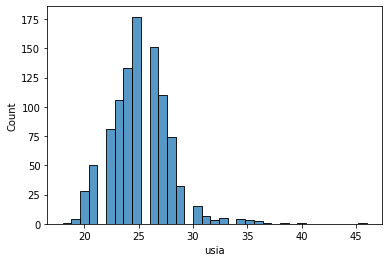

In [ ]:
sns.histplot(data=submission, x='usia')

In [ ]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      990 non-null    object
 1   usia    990 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.6+ KB


In [ ]:
submission.to_csv('submission_bener.csv', index=False)

In [ ]:
salah = pd.read_csv('/content/submission.csv')

In [ ]:
#bener = submission.copy()
mean_squared_error(bener,salah['usia'])

5.666666666666667